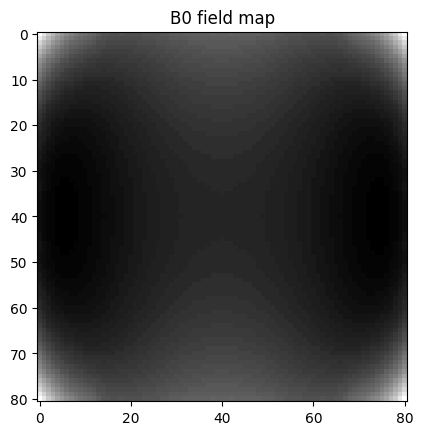

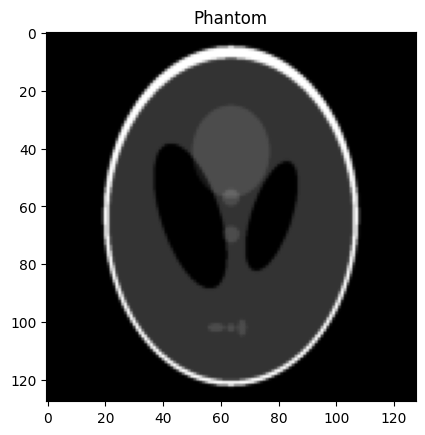

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.fft import fftshift, fft2, ifft2
from skimage.data import shepp_logan_phantom # type: ignore
from skimage.transform import resize
import pandas as pd
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import lsqr
from tqdm import tqdm


# Re-generate and resize Shepp-Logan phantom
phantom = shepp_logan_phantom()
phantom = resize(phantom, (128, 128))
phantom = phantom.astype(dtype=np.complex128)


N_spins = 128  # Number of spins in the phantom
# # Phantom is a 2D delta function (single point in the center)
# phantom = np.zeros((N_spins, N_spins), dtype=np.complex128)  
# phantom[N_spins//2, N_spins//2] = 1

# Load the B0 field map from the csv file
B0_field_map = pd.read_csv('2Dslice.csv', header=None).values

# Plot the B0 field map
plt.title('B0 field map')
plt.imshow(np.abs(B0_field_map), cmap='gray')
plt.show()

# Plot the phantom
plt.title('Phantom')
plt.imshow(np.abs(phantom), cmap='gray')
plt.show()


gamma = 42.58e6  # Gyromagnetic ratio for hydrogen in Hz/T
g_mult = 10 # Gradient multiplication factor
Gx = 0.004755753 * g_mult  # Gradient strength in T/m
Gy = 0.004755753 * g_mult # Gradient strength in T/m
#B0 = 1.0  # B0 field in T

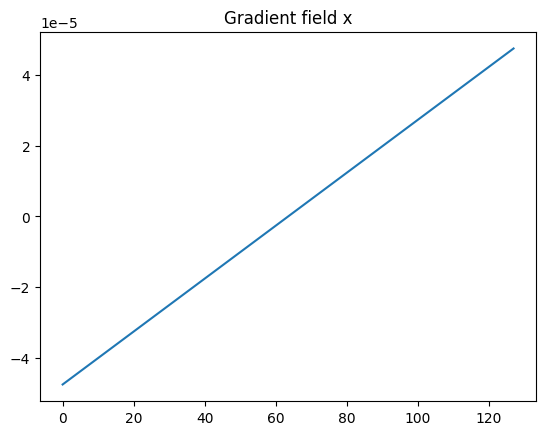

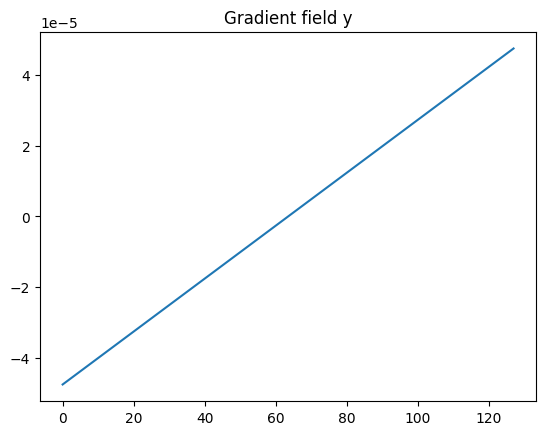

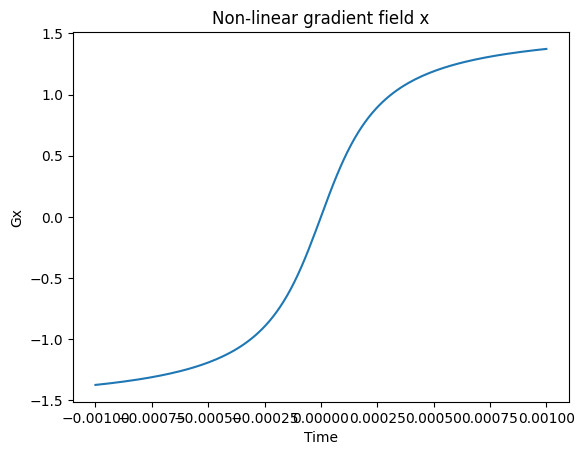

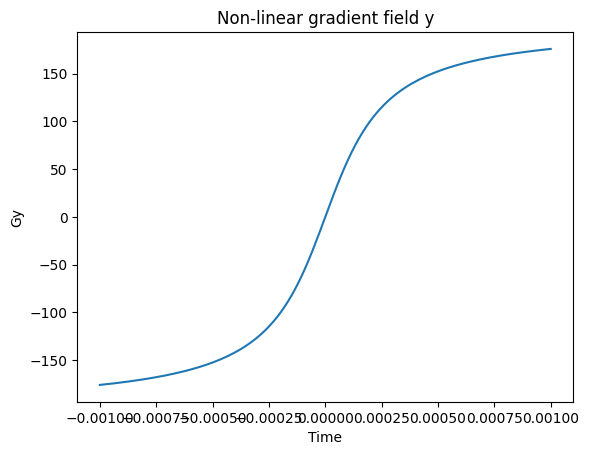

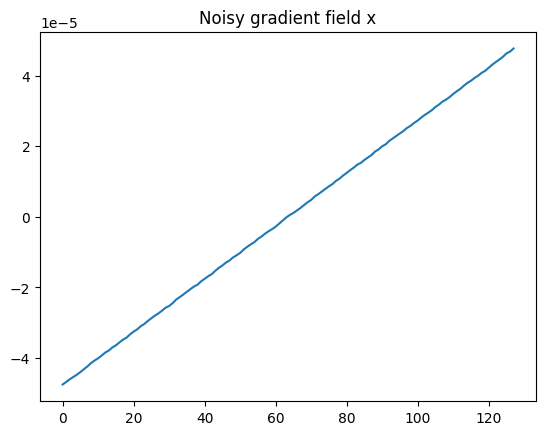

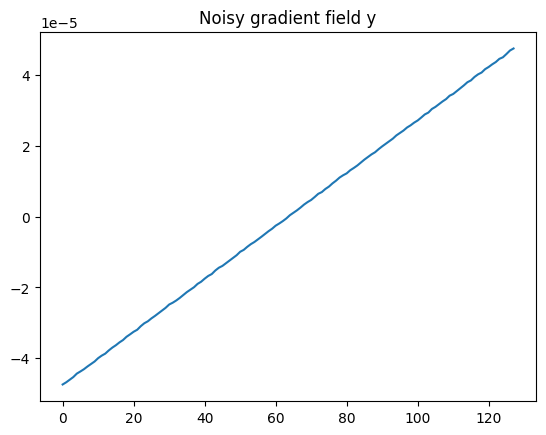

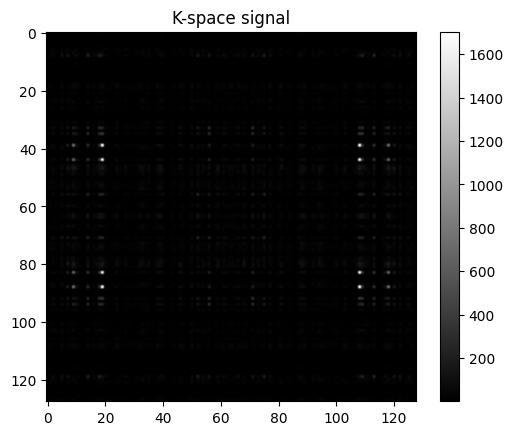

In [41]:
# Time intervals for the gradients
tau = 2e-3
time = np.linspace(-tau/2,tau/2,N_spins)

# Gradient fields (assuming same for x and y directions)
Gx_values = time * Gx
Gy_values = time * Gx


# Plot the gradient fields
plt.title('Gradient field x')
plt.plot(Gx_values)
plt.show()

plt.title('Gradient field y')
plt.plot(Gy_values)
plt.show()

# Compute gradient field strength using arctan model
Gx_values_nonlinear = np.arctan(time*5000)
Gy_values_nonlinear = 128 * np.arctan(time*5000)

# Plot the gradient fields
plt.title('Non-linear gradient field x')
plt.plot(time, Gx_values_nonlinear)
plt.xlabel('Time')
plt.ylabel('Gx')
plt.show()

plt.title('Non-linear gradient field y')
plt.plot(time, Gy_values_nonlinear)
plt.xlabel('Time')
plt.ylabel('Gy')
plt.show()

kx_values = gamma * Gx_values_nonlinear
ky_values = gamma * Gy_values_nonlinear



# Standard deviation of the noise
noise_std = 0.0000001 # example value, adjust as needed

# Gradient fields with added Gaussian noise
Gx_values_noisy = Gx_values + np.random.normal(0, noise_std, size=Gx_values.shape)
Gy_values_noisy = Gy_values + np.random.normal(0, noise_std, size=Gy_values.shape)

# Plot the gradient fields
plt.title('Noisy gradient field x')
plt.plot(Gx_values_noisy)
plt.show()

plt.title('Noisy gradient field y')
plt.plot(Gy_values_noisy)
plt.show()


# k-space trajectory (assuming same for x and y directions)
# kx_values = gamma * Gx_values
# ky_values = gamma * Gy_values

# Define field of view
FOV = .2  # meters
x_values = np.linspace(-FOV / 2, FOV / 2, N_spins)
y_values = np.linspace(-FOV / 2, FOV / 2, N_spins)
x_values, y_values = np.meshgrid(x_values, y_values, indexing='ij')  # Create 2D coordinate grid


# Compute k-space values
k_space = np.zeros((N_spins, N_spins), dtype=np.complex128)
for i, kx in enumerate(kx_values):
    for j, ky in enumerate(ky_values):
        k_space[i, j] = np.sum(phantom * np.exp(-1j * (kx * x_values + ky * y_values)))




# Plot the absolute k-space signal
plt.figure()
plt.imshow(np.abs(k_space), cmap='gray')
plt.title('K-space signal')
plt.colorbar()
plt.show()


In [42]:
# Reshape the k-space data into a vector
kspace_vec = np.reshape(k_space, (N_spins*N_spins))

E = np.zeros((N_spins**2, N_spins**2), dtype=np.complex128)

# Flatten the arrays to make them 1D
x_values_flat = x_values.flatten()
y_values_flat = y_values.flatten()
B0_field_map_flat = B0_field_map.flatten()

iterator = 0
for i, kx in tqdm(enumerate(kx_values)):
    for j, ky in enumerate(ky_values):
        # Use the flattened arrays in the calculation
        E[:, iterator] = np.exp(-1j * (kx * x_values_flat + ky * y_values_flat))
        iterator += 1


0it [00:00, ?it/s]

128it [00:22,  5.73it/s]


In [43]:
x_1, istop, itn, r1norm, r2norm, anorm, acond, arnorm, xnorm, var = lsqr(E, kspace_vec, iter_lim=200, show=True)
image_1 = np.reshape(x_1, (N_spins, N_spins))



 
LSQR            Least-squares solution of  Ax = b
The matrix A has 16384 rows and 16384 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =      200
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   6.275e+03  6.275e+03    1.0e+00  2.1e-02
     1 -5.62539e-03+3.41319e-11j   5.498e+03  5.498e+03    8.8e-01  4.1e-01   2.7e+02  1.0e+00
     2 3.91271e-04+1.10704e-10j   5.175e+03  5.175e+03    8.2e-01  2.1e-01   4.7e+02  2.5e+00
     3 9.83786e-03+1.08039e-09j   4.969e+03  4.969e+03    7.9e-01  1.1e-01   6.4e+02  4.3e+00
     4 1.72708e-02+3.01819e-09j   4.846e+03  4.846e+03    7.7e-01  7.5e-02   7.7e+02  6.1e+00
     5 2.27259e-02+5.97905e-09j   4.752e+03  4.752e+03    7.6e-01  6.2e-02   8.6e+02  8.2e+00
     6 2.45881e-02+8.93377e-09j   4.681e+03  4.681e+03    7.5e-01  5.0e-02   9.5e+02  1.0e+01
     7 2.12871e-02+1.11408e-08j   4.626e+

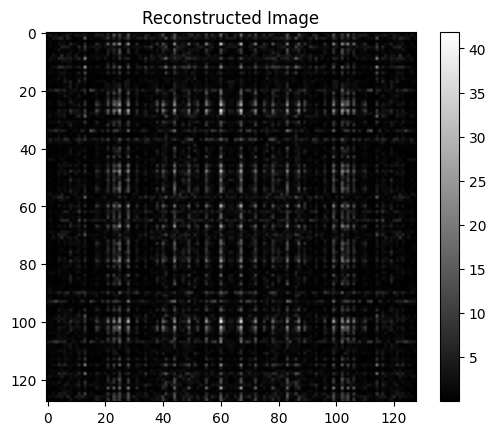

In [44]:
plt.figure()
plt.imshow(np.abs(image_1), cmap='gray')
plt.colorbar()
plt.title('Reconstructed Image')
plt.show()